In [67]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, skew, kurtosis
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_validate, cross_val_predict
from sklearn.feature_selection import VarianceThreshold,SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.feature_selection import mutual_info_classif
import shap


## 1. Load data & preprocess data

In [68]:
# Load dataset
df = pd.read_csv("Assignment_data.csv")

In [69]:
df.head()

,device,score,time
0,352610060979119,7,1421157320
1,352610060979119,0,1421157288
2,352610060979119,6,1421157344
3,99000072289368,106,1421163166
4,357470044931974,278,1421163783


In [70]:
# Check missing values
missing_values_count = df.isnull().sum()
print("Before dropping missing value:", missing_values_count)

# Drop missing value in Devide column
df['device'] = df['device'].replace(["", " "], np.nan)
df = df.dropna(subset=['device'])

print("After dropping missing value:", df.isnull().sum())

Before dropping missing value: device    9
score     0
time      0
dtype: int64
After dropping missing value: device    0
score     0
time      0
dtype: int64


In [71]:
# Convert Unix time to datetime format
df['converted_time'] = pd.to_datetime(df['time'], unit='s', origin='unix')

# Split datetime into separate date and time columns
df['date'] = df['converted_time'].dt.date  # extract date
df['time_hr'] = df['converted_time'].dt.strftime('%H:%M:%S')  # extract time in HH:MM:SS format
df['hour_of_day'] = df['converted_time'].dt.hour
df['day_of_week'] = df['converted_time'].dt.day_name()
df['month'] = df['converted_time'].dt.month
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int) # Weekend=1, weekday=0
df['is_night'] = df['hour_of_day'].isin([0, 1, 2, 3, 4, 5, 22, 23]).astype(int) # Night=1, day=0
df.head()

,device,score,time,converted_time,date,time_hr,hour_of_day,day_of_week,month,is_weekend,is_night
0,352610060979119,7,1421157320,2015-01-13 13:55:20,2015-01-13,13:55:20,13,Tuesday,1,0,0
1,352610060979119,0,1421157288,2015-01-13 13:54:48,2015-01-13,13:54:48,13,Tuesday,1,0,0
2,352610060979119,6,1421157344,2015-01-13 13:55:44,2015-01-13,13:55:44,13,Tuesday,1,0,0
3,99000072289368,106,1421163166,2015-01-13 15:32:46,2015-01-13,15:32:46,15,Tuesday,1,0,0
4,357470044931974,278,1421163783,2015-01-13 15:43:03,2015-01-13,15:43:03,15,Tuesday,1,0,0


## 2. Exploratory Data Analysis

In [72]:
# Count unique device values, which are unique players
unique_device_count = df['device'].nunique()
print("Number of unique device values:", unique_device_count)

Number of unique device values: 25956


### 2.1 Time Analysis

In [73]:
# Date range in the dataset
earliest_date = df['converted_time'].min().date()
latest_date = df['converted_time'].max().date()
print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 2015-01-13
Latest date: 2016-05-24


Player Lifetime Distribution:
count    25956.000000
mean         9.061219
std         39.746446
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%         11.000000
95%         45.000000
99%        232.000000
max        480.000000
Name: lifetime_days, dtype: float64


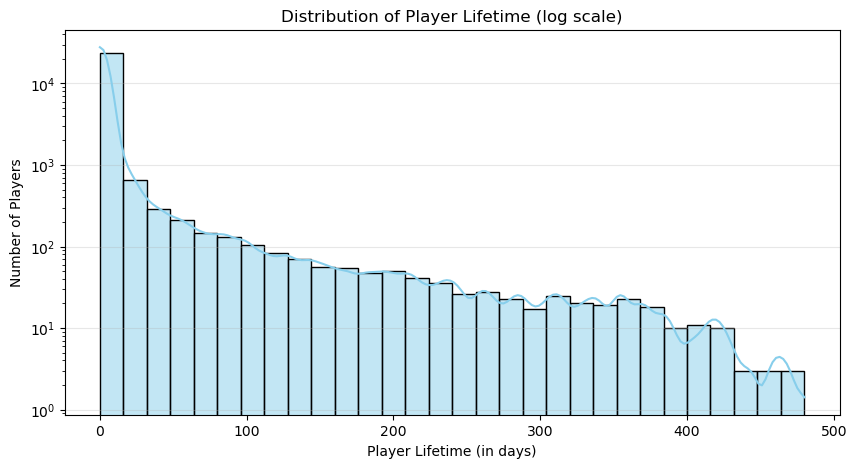

In [74]:
# Player lifetime analysis
player_lifetime = df.groupby('device').agg(first_session=('converted_time', 'min'),last_session=('converted_time', 'max'),
    total_sessions=('score', 'count')).reset_index()
player_lifetime['lifetime_days'] = (player_lifetime['last_session'] - player_lifetime['first_session']).dt.days

print("Player Lifetime Distribution:")
print(player_lifetime['lifetime_days'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
# Visualization 
plt.figure(figsize=(10, 5))
sns.histplot(player_lifetime['lifetime_days'], bins=30, kde=True, color='skyblue')
plt.yscale('log')
plt.xlabel('Player Lifetime (in days)')
plt.ylabel('Number of Players')
plt.title('Distribution of Player Lifetime (log scale)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# WHY THIS MATTERS: 
# - Shows you the natural "drop-off" points
# - Helps justify your CP period choice
# - If 95% of players leave within X days, your CP should be around X

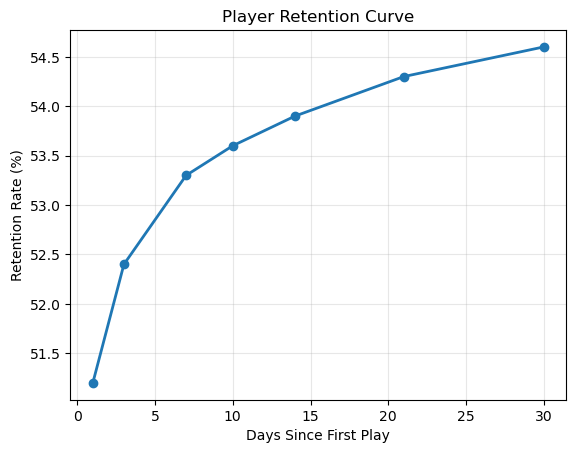

Retention Rate:
   Day  Retention_Rate
0    1           0.512
1    3           0.524
2    7           0.533
3   10           0.536
4   14           0.539
5   21           0.543
6   30           0.546


In [75]:
# Rentention rate - How many percentages of players come back after N days?
def retention_rate(df):    
    player_sessions = df.groupby('device')['converted_time'].apply(list).reset_index()
    retention_data = []
    for days in [1, 3, 7, 10, 14, 21, 30]:
        retained = 0
        for idx, row in player_sessions.iterrows():
            sessions = sorted(row['converted_time'])
            first_session = sessions[0]
            # If player returned within N days
            future_sessions = [s for s in sessions if (s - first_session).days <= days]
            if len(future_sessions) > 1:
                retained += 1
        retention_rate = round(retained / len(player_sessions),3)
        retention_data.append({'Day': days, 'Retention_Rate': retention_rate})
    return pd.DataFrame(retention_data)
retention_df = retention_rate(df)

# Visualization
plt.plot(retention_df['Day'], retention_df['Retention_Rate'] * 100, marker='o', linewidth=2)
plt.xlabel('Days Since First Play')
plt.ylabel('Retention Rate (%)')
plt.title('Player Retention Curve')
plt.grid(alpha=0.3)
plt.show()

print("Retention Rate:")
print(retention_df)

# WHY THIS MATTERS:
# - Industry benchmark: Good mobile games have 40%+ Day 1 retention
# - Shows where the biggest drop-offs occur
# - Helps you decide: should you predict early churn (Day 1-3) or late churn (Day 7+)?



### 2.2 Score Analysis

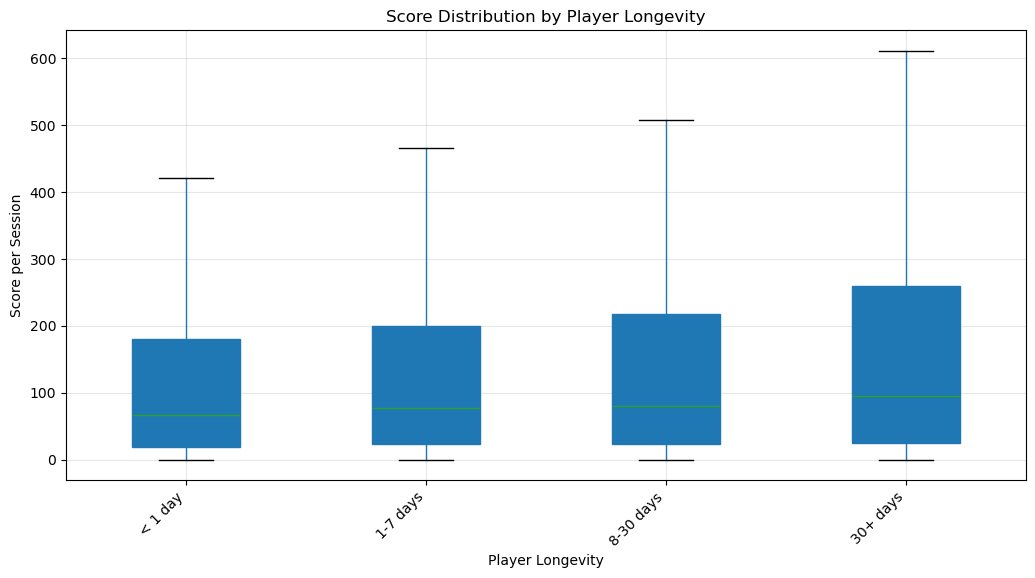

Mean Scores by Longevity:
                 mean  median         std
longevity                                
< 1 day    170.670992    67.0  397.108180
1-7 days   188.484247    77.0  438.368089
8-30 days  196.322240    81.0  449.597353
30+ days   233.387821    95.0  477.780575


C:\Users\minht\AppData\Local\Temp\ipykernel_32636\2148423583.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_with_lifetime.groupby('longevity')['score'].agg(['mean', 'median', 'std']))


In [76]:
# Score Distribution by Player Longevity
df_with_lifetime = df.merge(player_lifetime[['device', 'lifetime_days', 'total_sessions']], on='device')

# Categorize by lifetime
df_with_lifetime['longevity'] = pd.cut(df_with_lifetime['lifetime_days'],bins=[0, 1, 7, 30, np.inf],
    labels=['< 1 day', '1-7 days', '8-30 days', '30+ days'])

# Boxplot comparison
plt.figure(figsize=(12, 6))
df_with_lifetime.boxplot(column='score', by='longevity', ax=plt.gca(), patch_artist=True, showfliers=False)
plt.suptitle('')  # Remove default title
plt.title('Score Distribution by Player Longevity')
plt.xlabel('Player Longevity')
plt.ylabel('Score per Session')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()

# Statistical test
print("Mean Scores by Longevity:")
print(df_with_lifetime.groupby('longevity')['score'].agg(['mean', 'median', 'std']))

# WHY THIS MATTERS:
# - If churned players have LOWER scores → frustration-driven churn
# - If NO difference → skill doesn't matter, it's engagement/addiction mechanics
# - This tells you if "avg_score" will be a good feature

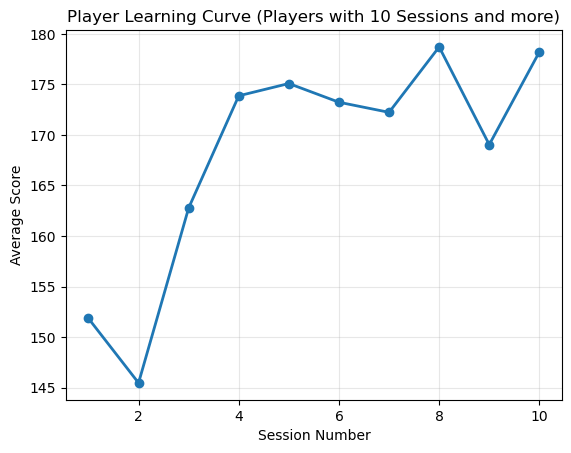

In [77]:
# Check score trend of player who play more than 10 sessions
session_counts = df['device'].value_counts()
df_10 = df[df['device'].isin(session_counts[session_counts >= 10].index)]

# Take first 10 sessions ONLY for players with >= 10 sessions
first_sessions = df_10.groupby('device').head(10).copy()

# Assign session numbers 1–10
first_sessions['session_number'] = first_sessions.groupby('device').cumcount() + 1

# Compute mean score per session number
learning_curve = (first_sessions.groupby('session_number')['score'] .mean().reset_index())

plt.plot(learning_curve['session_number'],learning_curve['score'],marker='o', linewidth=2)
plt.xlabel('Session Number')
plt.ylabel('Average Score')
plt.title('Player Learning Curve (Players with 10 Sessions and more)')
plt.grid(alpha=0.3)
plt.show()


# WHY THIS MATTERS:
# - If score INCREASES → players are learning (good onboarding)
# - If score FLAT → game might be too hard/easy or tutorial is bad
# - "Score trend" will be a powerful feature

In [78]:
# Percentage of zero scores per player
zero_score_pct = df.groupby('device')['score'].apply(lambda x: (x == 0).mean()).reset_index()
zero_score_pct.columns = ['device', 'zero_pct']

# Merge with lifetime
zero_score_pct = zero_score_pct.merge(player_lifetime[['device', 'lifetime_days']], on='device')
zero_score_pct['churned'] = (zero_score_pct['lifetime_days'] <= 7).astype(int)

print("\nZero Score Analysis:")
print(zero_score_pct.groupby('churned')['zero_pct'].describe())

# WHY THIS MATTERS:
# - High zero-score % might indicate frustration → churn
# - This becomes the "zero_score_pct" feature


Zero Score Analysis:
           count      mean       std  min  25%  50%       75%  max
churned                                                           
0         2913.0  0.026058  0.067813  0.0  0.0  0.0  0.017544  0.5
1        23043.0  0.026856  0.127376  0.0  0.0  0.0  0.000000  1.0


### 2.3 Session Analysis

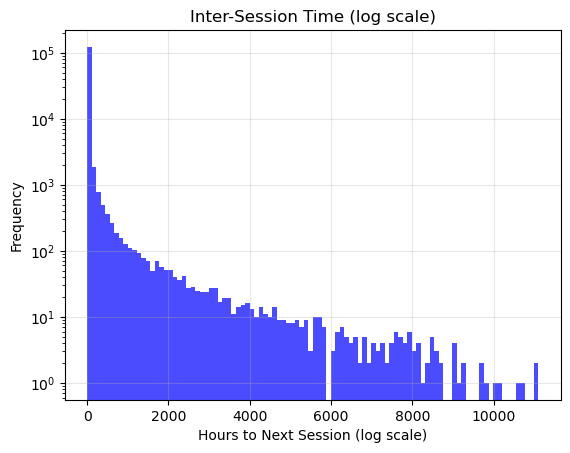


Inter-Session Time Analysis:
count    127964.000000
mean         44.755968
std         355.189708
min           0.000000
25%           0.007500
50%           0.015278
75%           0.060000
90%          20.912861
95%          87.611972
99%        1133.941414
max       11096.131389
Name: time_to_next_hours, dtype: float64


In [79]:
# Inter-Session Time (time between sessions for the same player)

df_sorted = df.sort_values(['device', 'converted_time'])
df_sorted['time_to_next'] = df_sorted.groupby('device')['converted_time'].shift(-1)
df_sorted['time_to_next_hours'] = (df_sorted['time_to_next'] - df_sorted['converted_time']).dt.total_seconds() / 3600

# Remove one time player
inter_session = df_sorted.dropna(subset=['time_to_next_hours'])

# Visualization: Distribution with log scale
plt.hist(inter_session['time_to_next_hours'], bins=100, alpha=0.7, color='blue')
plt.xlabel('Hours to Next Session (log scale)')
plt.ylabel('Frequency')
plt.title('Inter-Session Time (log scale)')
plt.yscale('log') # Normal scale doesn't show distribution well
plt.grid(alpha=0.3)
plt.show()

# Key percentiles
print("\nInter-Session Time Analysis:")
print(inter_session['time_to_next_hours'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# WHY THIS MATTERS:
# - If median is < 1 hour → players play in bursts (multiple sessions/day)
# - If 90th percentile is < 24 hours → most active players return daily
# - Gaps > 7 days usually indicate churn

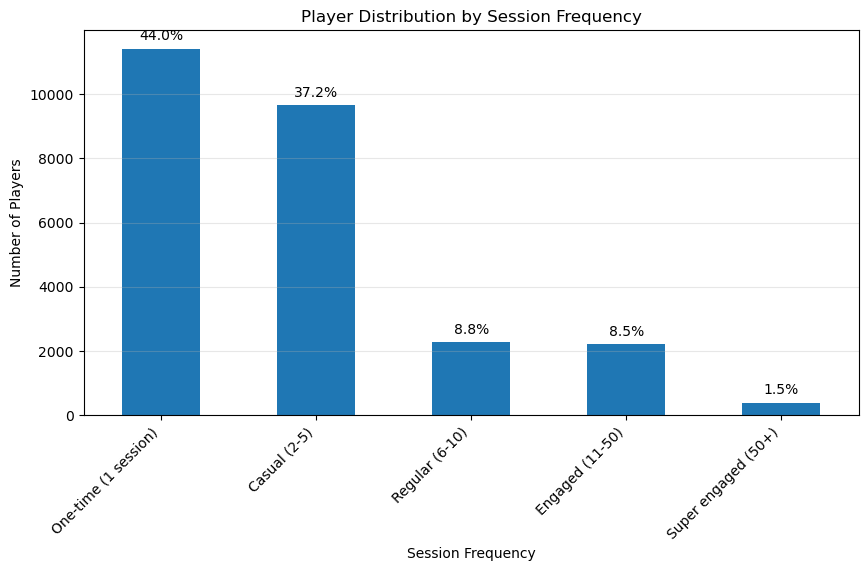


Session Frequency Distribution:
session_frequency
One-time (1 session)    0.440052
Casual (2-5)            0.371860
Regular (6-10)          0.087725
Engaged (11-50)         0.085260
Super engaged (50+)     0.015102
Name: proportion, dtype: float64


In [80]:
# Session Frequency
session_counts = df.groupby('device').size().reset_index(name='session_count')
session_counts['session_frequency'] = pd.cut(
    session_counts['session_count'],
    bins=[0, 1, 5, 10, 50, np.inf],
    labels=['One-time (1 session)', 'Casual (2-5)', 'Regular (6-10)', 'Engaged (11-50)', 'Super engaged (50+)']
)

# Visualization
plt.figure(figsize=(10, 5))
session_counts['session_frequency'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Session Frequency')
plt.ylabel('Number of Players')
plt.title('Player Distribution by Session Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
total = len(session_counts)
for i, v in enumerate(session_counts['session_frequency'].value_counts().sort_index()):
    plt.text(i, v + total*0.01, f'{v/total*100:.1f}%', ha='center')

plt.show()

print("\nSession Frequency Distribution:")
print(session_counts['session_frequency'].value_counts(normalize=True).sort_index())

# WHY THIS MATTERS:
# - If >50% are "one-timers" → huge early churn problem
# - Power users are your revenue source → need different retention strategy
# - This segmentation can be a FEATURE in your model

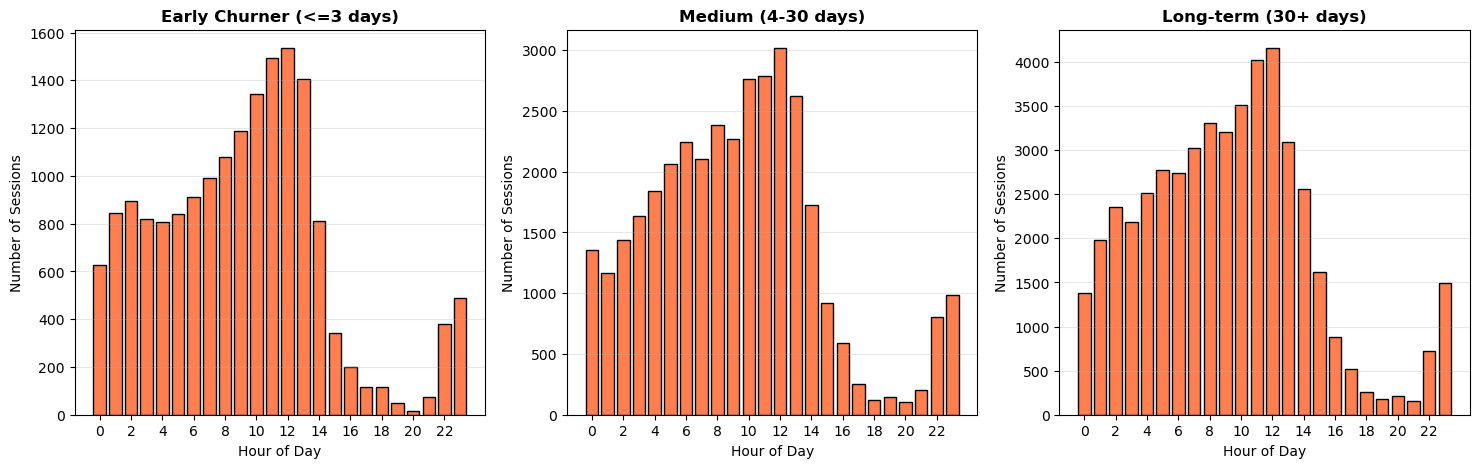

In [81]:
# Hour of Day Analysis
hourly_data = df.merge(player_lifetime[['device', 'lifetime_days']], on='device')
hourly_data['player_category'] = pd.cut(hourly_data['lifetime_days'],bins=[0, 3, 30, np.inf],
    labels=['Early Churner (<=3 days)', 'Medium (4-30 days)', 'Long-term (30+ days)'])

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, category in enumerate(['Early Churner (<=3 days)', 'Medium (4-30 days)', 'Long-term (30+ days)']):
    ax = axes[idx]
    data = hourly_data[hourly_data['player_category'] == category]
    
    hour_dist = data['hour_of_day'].value_counts().sort_index()
    ax.bar(hour_dist.index, hour_dist.values, color='coral', edgecolor='black')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Sessions')
    ax.set_title(category,fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticks(range(0, 24, 2))

plt.show()

# WHY THIS MATTERS:
# - Do churners play at different times? (e.g., late night → less engaged)
# - "Peak hour" and "hour diversity" will be features

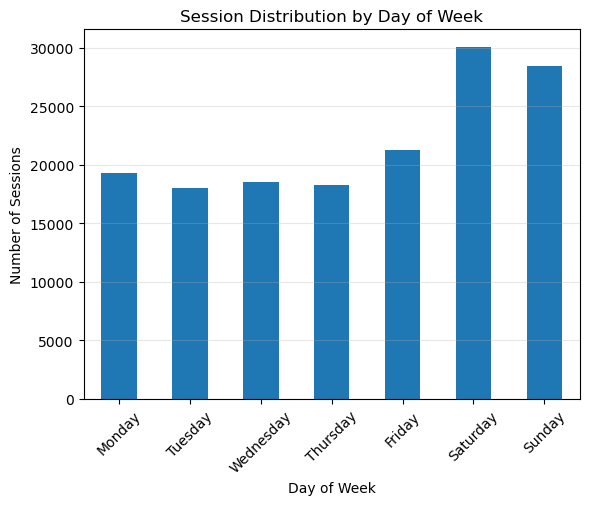

In [82]:
# Define order for days of the week
df['day_of_week'] = df['converted_time'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

day_dist = df['day_of_week'].value_counts().sort_index()
#Visualization
day_dist.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Sessions')
plt.title('Session Distribution by Day of Week')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


# WHY THIS MATTERS:
# - Weekend-only players might be more casual → higher churn?
# - "Weekend ratio" will be a feature

## 3. Create churn and no-churn label

In [83]:
def create_churn_labels(df, OP_days, CP_days):
    # Find each player's t0 (first play)
    t0 = df.groupby('device')['converted_time'].min().rename('t0')

    # create windows (OP and CP)
    windows = t0.reset_index().copy()
    windows['OP_start'] = windows['t0']
    windows['OP_end'] = windows['t0'] + pd.Timedelta(days=OP_days)
    windows['CP_end'] = windows['OP_end'] + pd.Timedelta(days=CP_days)
    # Merge to assign sessions to windows
    tmp = df.merge(windows[['device','OP_start','OP_end','CP_end']], on='device', how='left')
    tmp['in_OP'] = (tmp['converted_time'] >= tmp['OP_start']) & (tmp['converted_time'] < tmp['OP_end'])
    tmp['in_CP'] = (tmp['converted_time'] >= tmp['OP_end']) & (tmp['converted_time'] < tmp['CP_end'])

    # churn label per device
    counts = tmp.groupby('device').agg(op_sessions=('in_OP','sum'), cp_sessions=('in_CP','sum')).reset_index()
    counts['churn'] = np.where((counts['op_sessions']>=1) & (counts['cp_sessions']==0), 1,
                    np.where((counts['op_sessions']>=1) & (counts['cp_sessions']>0), 0, np.nan))
    counts = counts.dropna(subset=['churn'])
    return windows, counts


In [84]:
windows, counts = create_churn_labels(df, OP_days=7, CP_days=14)

In [85]:
# Check churn distribution
print("Churn distribution:")
print(counts['churn'].value_counts(dropna=False))

print("\nProportion:")
print(counts['churn'].value_counts(normalize=True, dropna=False))

Churn distribution:
churn
1.0    24197
0.0     1759
Name: count, dtype: int64

Proportion:
churn
1.0    0.932231
0.0    0.067769
Name: proportion, dtype: float64


In [86]:
# Merge with churn labels
windows = windows.merge(counts[['device', 'churn']], on='device', how='left')

In [87]:
windows.head()

,device,t0,OP_start,OP_end,CP_end,churn
0,0,2015-04-11 11:52:38,2015-04-11 11:52:38,2015-04-18 11:52:38,2015-05-02 11:52:38,1.0
1,000000000000000,2015-01-23 02:04:44,2015-01-23 02:04:44,2015-01-30 02:04:44,2015-02-13 02:04:44,1.0
2,010941525590041,2015-07-07 10:33:00,2015-07-07 10:33:00,2015-07-14 10:33:00,2015-07-28 10:33:00,1.0
3,012345678901237,2015-02-23 03:24:43,2015-02-23 03:24:43,2015-03-02 03:24:43,2015-03-16 03:24:43,1.0
4,012345678912345,2015-02-22 08:51:46,2015-02-22 08:51:46,2015-03-01 08:51:46,2015-03-15 08:51:46,1.0


## 4. Feature Engineering

In [88]:
def features_engineer(df, windows, OP_days):
    # Filter for OP sessions only
    tmp = df.merge(windows[['device','OP_start','OP_end','CP_end']], on='device', how='left')
    tmp['in_OP'] = (tmp['converted_time'] >= tmp['OP_start']) & (tmp['converted_time'] < tmp['OP_end'])
    df_OP = tmp[tmp['in_OP'] == True].copy()
    # Basic statistics
    features = df_OP.groupby('device').agg(
        total_sessions=('score', 'count'),
        total_score=('score', 'sum'),
        avg_score=('score', 'mean'),
        max_score=('score', 'max'),
        min_score=('score', 'min'),
        median_score=('score', 'median'),
        std_score=('score', 'std'),
        first_play=('converted_time', 'min'),
        last_play=('converted_time', 'max')
    ).reset_index()
    
    # Score distribution features    
    features['score_range'] = features['max_score'] - features['min_score']
    features['score_cv'] = features['std_score'] / (features['avg_score'] + 1)  # coefficient of variation
    
    score_skew = df_OP.groupby('device')['score'].apply(
        lambda x: skew(x) if len(x) > 2 else 0
    ).rename('score_skewness')
    features = features.merge(score_skew.reset_index(), on='device', how='left')
    
    score_kurt = df_OP.groupby('device')['score'].apply(
        lambda x: kurtosis(x) if len(x) > 2 else 0
    ).rename('score_kurtosis')
    features = features.merge(score_kurt.reset_index(), on='device', how='left')
    
    def calculate_entropy(scores):
        if len(scores) < 2:
            return 0
        value_counts = pd.Series(scores).value_counts(normalize=True)
        return entropy(value_counts)
    
    score_entropy = df_OP.groupby('device')['score'].apply(calculate_entropy).rename('score_entropy')
    features = features.merge(score_entropy.reset_index(), on='device', how='left')
    
    zero_pct = df_OP.groupby('device')['score'].apply(lambda x: (x == 0).mean()).rename('zero_score_pct')
    features = features.merge(zero_pct.reset_index(), on='device', how='left')
    
    score_75 = df_OP['score'].quantile(0.75)
    high_score_pct = df_OP.groupby('device')['score'].apply(
        lambda x: (x > score_75).mean()
    ).rename('high_score_pct')
    features = features.merge(high_score_pct.reset_index(), on='device', how='left')
    
    # Session patterns features    
    features['activity_days'] = (features['last_play'] - features['first_play']).dt.days + 1
    features['sessions_per_day'] = features['total_sessions'] / features['activity_days']
    features['score_per_session'] = features['total_score'] / features['total_sessions']
    features['active_days_ratio'] = features['activity_days'] / OP_days
    features['session_span_days'] = (features['last_play'] - features['first_play']).dt.total_seconds() / (3600 * 24)
    features['recency_days'] = (features['last_play'].max() - features['last_play']).dt.total_seconds() / (3600 * 24)

    # Inter-session patterns features
    def calc_mean_interval(group):
        times = group.sort_values()
        if len(times) <= 1:
            return 0
        intervals = times.diff().dropna().dt.total_seconds() / 3600
        return intervals.mean()
    
    def calc_median_interval(group):
        times = group.sort_values()
        if len(times) <= 1:
            return 0
        intervals = times.diff().dropna().dt.total_seconds() / 3600
        return intervals.median()
    
    def calc_interval_cv(group):
        times = group.sort_values()
        if len(times) <= 1:
            return 0
        intervals = times.diff().dropna().dt.total_seconds() / 3600
        if intervals.mean() == 0 or intervals.std() == 0:
            return 0
        return intervals.std() / intervals.mean()
    
    mean_interval = df_OP.groupby('device')['converted_time'].apply(calc_mean_interval).rename('mean_interval_hours')
    features = features.merge(mean_interval.reset_index(), on='device', how='left')
    
    median_interval = df_OP.groupby('device')['converted_time'].apply(calc_median_interval).rename('median_interval_hours')
    features = features.merge(median_interval.reset_index(), on='device', how='left')
    
    interval_cv = df_OP.groupby('device')['converted_time'].apply(calc_interval_cv).rename('interval_cv')
    features = features.merge(interval_cv.reset_index(), on='device', how='left')
    
    # Score features
    def calc_score_trend(group):
        if len(group) < 2:
            return 0
        y = group['score'].values
        t = (group['converted_time'] - group['converted_time'].min()).dt.total_seconds()
        if np.all(y == y[0]) or np.all(t == 0):
            return 0
        try:
            slope = np.polyfit(t, y, 1)[0]
        except:
            slope = 0
        return slope
    
    trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
    features = features.merge(trend.reset_index(), on='device', how='left')
    
    def calc_early_late_ratio(group):
        if len(group) < 4:
            return 1.0
        mid = len(group) // 2
        early_mean = group.iloc[:mid]['score'].mean()
        late_mean = group.iloc[mid:]['score'].mean()
        return late_mean / (early_mean + 1)
    
    el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
    features = features.merge(el_ratio.reset_index(), on='device', how='left')
    
    # First session score vs average
    first_score = df_OP.groupby('device')['score'].first().rename('first_session_score')
    features = features.merge(first_score.reset_index(), on='device', how='left')
    features['first_vs_avg_ratio'] = features['first_session_score'] / (features['avg_score'] + 1)
    
    # Last session score vs average (recent engagement)
    last_score = df_OP.groupby('device')['score'].last().rename('last_session_score')
    features = features.merge(last_score.reset_index(), on='device', how='left')
    features['last_vs_avg_ratio'] = features['last_session_score'] / (features['avg_score'] + 1)
    
    # Max sessions in a single day (binge playing)
    max_sessions_day = df_OP.groupby(['device', df_OP['converted_time'].dt.date]).size()\
        .groupby('device').max().rename('max_sessions_per_day')
    features = features.merge(max_sessions_day.reset_index(), on='device', how='left')
    
    # Session concentration (Gini coefficient)
    def calc_session_gini(group):
        sessions_per_day = group.groupby(group['converted_time'].dt.date).size().values
        if len(sessions_per_day) <= 1:
            return 0
        sorted_sessions = np.sort(sessions_per_day)
        n = len(sorted_sessions)
        cumsum = np.cumsum(sorted_sessions)
        return (2 * np.sum((np.arange(1, n+1)) * sorted_sessions)) / (n * np.sum(sorted_sessions)) - (n + 1) / n
    
    gini = df_OP.groupby('device').apply(calc_session_gini).rename('session_gini')
    features = features.merge(gini.reset_index(), on='device', how='left')
        
    # Weekend play ratio
    weekend_ratio = df_OP.groupby('device')['is_weekend'].mean().rename('weekend_ratio')
    features = features.merge(weekend_ratio.reset_index(), on='device', how='left')
    
    # Night play ratio
    night_ratio = df_OP.groupby('device')['is_night'].mean().rename('night_play_ratio')
    features = features.merge(night_ratio.reset_index(), on='device', how='left')
    
    # Peak hour (most common play hour)
    def get_peak_hour(x):
        mode_result = x.mode()
        return mode_result[0] if len(mode_result) > 0 else 12
    
    peak_hour = df_OP.groupby('device')['hour_of_day'].apply(get_peak_hour).rename('peak_hour')
    features = features.merge(peak_hour.reset_index(), on='device', how='left')
    
    # Hour diversity (entropy of play hours)
    def calc_hour_entropy(hours):
        if len(hours) < 2:
            return 0
        value_counts = pd.Series(hours).value_counts(normalize=True)
        return entropy(value_counts)
    
    hour_ent = df_OP.groupby('device')['hour_of_day'].apply(calc_hour_entropy).rename('hour_entropy')
    features = features.merge(hour_ent.reset_index(), on='device', how='left')
    
    # Average hour of play (continuous variable)
    avg_hour = df_OP.groupby('device')['hour_of_day'].mean().rename('avg_hour_of_day')
    features = features.merge(avg_hour.reset_index(), on='device', how='left')
    
    # Drop intermediate columns
    features = features.drop(columns=['first_play', 'last_play', 'first_session_score', 'last_session_score'], errors='ignore')
    
    # Fill missing values
    features = features.fillna(0)
    features = features.replace([np.inf, -np.inf], 0)
    
    print(f" Created {len(features.columns)-1} features")
    
    return features


In [90]:
# Merge features with churn labels
OP_days = 7
features = features_engineer(df, windows, OP_days=7)

# Merge churn label (assuming 'churn' column exists in windows)
features = features.merge(windows[['device', 'churn']], on='device', how='left')

print(features.shape)
features.head()

C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
C:\Users\minht\AppDat

 Created 34 features
(25956, 36)


,device,total_sessions,total_score,avg_score,max_score,min_score,median_score,std_score,score_range,score_cv,...,first_vs_avg_ratio,last_vs_avg_ratio,max_sessions_per_day,session_gini,weekend_ratio,night_play_ratio,peak_hour,hour_entropy,avg_hour_of_day,churn
0,0,3,174,58.000000,115,14,45.0,51.739733,101,0.876945,...,0.762712,0.237288,3,0.0,1.0,0.0,11,0.0,11.0,1.0
1,000000000000000,3,10,3.333333,7,1,2.0,3.214550,6,0.741819,...,0.230769,0.461538,3,0.0,0.0,1.0,2,0.0,2.0,1.0
2,010941525590041,1,21,21.000000,21,21,21.0,0.000000,0,0.000000,...,0.954545,0.954545,1,0.0,0.0,0.0,10,0.0,10.0,1.0
3,012345678901237,2,65,32.500000,33,32,32.5,0.707107,1,0.021108,...,0.985075,0.955224,2,0.0,0.0,1.0,3,0.0,3.0,1.0
4,012345678912345,5,56,11.200000,30,0,3.0,13.479614,30,1.104886,...,0.245902,2.459016,5,0.0,1.0,0.0,8,0.0,8.0,1.0


In [91]:
# Prepare data
X = features.drop(columns=['device', 'churn'])
y = features['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 5. Feature Selection

In [94]:
# Step 1: Remove Low Variance Features
var_threshold = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_variance = var_threshold.fit_transform(X)
selected_features = X.columns[var_threshold.get_support()].tolist()
X_step1 = X[selected_features].copy()

  Found 13 highly correlated pairs (r > 0.9)
  - Removing 'max_sessions_per_day' (corr=0.905 with 'total_sessions')
  - Removing 'min_score' (corr=0.909 with 'avg_score')
  - Removing 'avg_score' (corr=0.983 with 'median_score')
  - Removing 'avg_score' (corr=1.000 with 'score_per_session')
  - Removing 'min_score' (corr=0.934 with 'median_score')
  - Removing 'min_score' (corr=0.909 with 'score_per_session')
  - Removing 'score_per_session' (corr=0.983 with 'median_score')
  - Removing 'std_score' (corr=0.924 with 'score_range')
  - Removing 'activity_days' (corr=1.000 with 'active_days_ratio')
  - Removing 'activity_days' (corr=0.988 with 'session_span_days')
  - Removing 'active_days_ratio' (corr=0.988 with 'session_span_days')
  - Removing 'median_interval_hours' (corr=0.943 with 'mean_interval_hours')
  - Removing 'peak_hour' (corr=0.958 with 'avg_hour_of_day')
  Removed 9 correlated features
  Remaining: 34 features


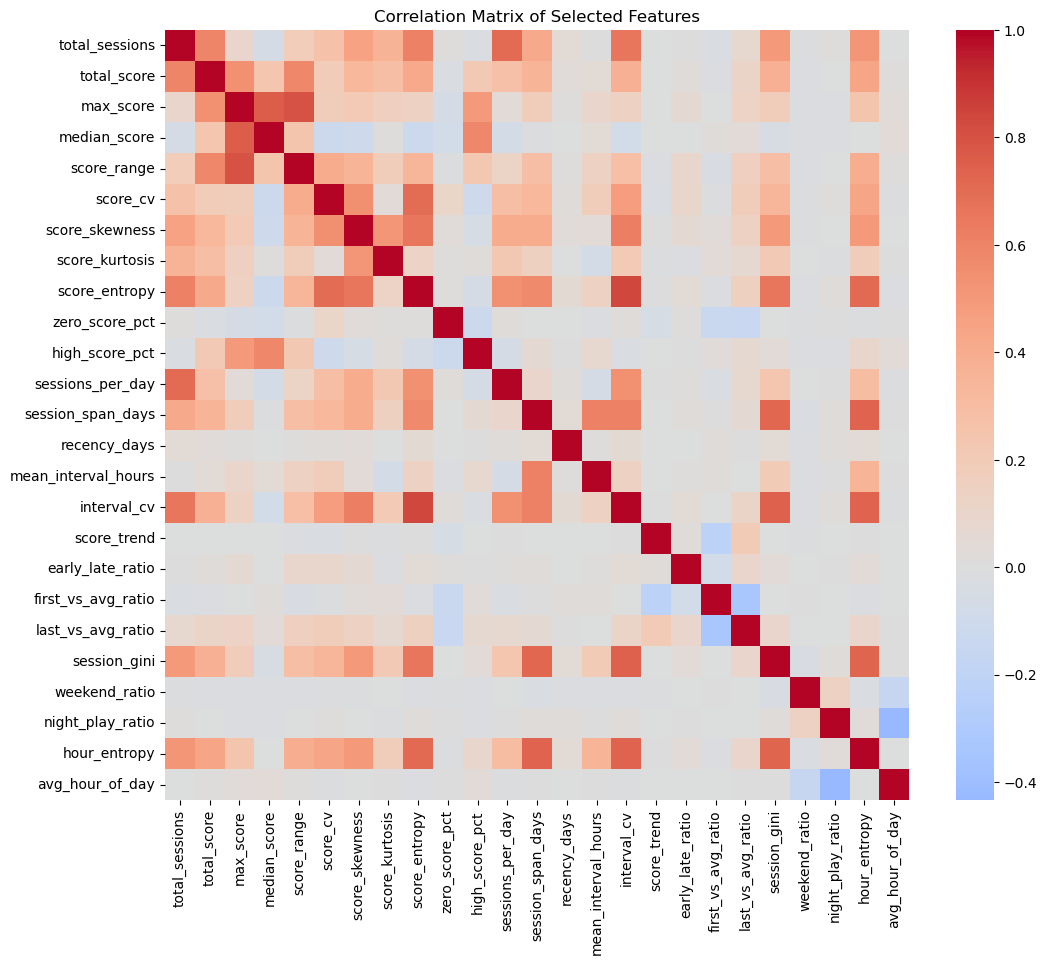

In [100]:
# Step 2: Correlation Analysis
corr_matrix = X_step1.corr().abs()
# Find pairs of highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:  # threshold: 90% correlation
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

print(f"  Found {len(high_corr_pairs)} highly correlated pairs (r > 0.9)")
# For highly correlated pairs, keep the one with higher importance from Random Forest
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_importance.fit(X_step1, y)

importance_dict = dict(zip(X_step1.columns, rf_importance.feature_importances_))

features_to_remove = set()
for pair in high_corr_pairs:
    f1, f2 = pair['feature1'], pair['feature2']
    # Remove the feature with lower importance
    if importance_dict[f1] < importance_dict[f2]:
        features_to_remove.add(f1)
    else:
        features_to_remove.add(f2)
    print(f"  - Removing '{f1 if importance_dict[f1] < importance_dict[f2] else f2}' "
          f"(corr={pair['correlation']:.3f} with '{f2 if importance_dict[f1] < importance_dict[f2] else f1}')")

X_final = X_step1.drop(columns=list(features_to_remove))
print(f"  Removed {len(features_to_remove)} correlated features")
print(f"  Remaining: {X_step1.shape[1]} features")

# Heatmap of remaining features correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_final.corr(), cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()


## 6. Handle class imbalance (50% with SMOTE)

In [101]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Only balance to 50%
X_processed, y_processed = smote.fit_resample(X_final, y)
    
print(f"Class distribution after processing: {pd.Series(y_processed).value_counts().to_dict()}")

Class distribution after processing: {1.0: 24197, 0.0: 12098}


## 7. Model Training 

In [102]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_processed
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 29036
Test set size: 7259


In [103]:
# Define stratified 5-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Store results for all models
cv_results_all = {}

### 7.1 Train Random Forest model

In [104]:
# Train random forest model with final features
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
# Perform cross-validation on training set
rf_cv_results = cross_validate(
    rf_model, 
    X_train, 
    y_train, 
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Store CV results
cv_results_all['Random Forest'] = rf_cv_results

# Train on full training set
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_rf))

test_metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
}

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
test_metrics_rf['PR-AUC'] = auc(recall_rf, precision_rf)

print("\nTest Set Metrics Summary:")
for metric, value in test_metrics_rf.items():
    print(f"  {metric:<12}: {value:.4f}")



Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      2420
         1.0       0.95      0.96      0.96      4839

    accuracy                           0.94      7259
   macro avg       0.94      0.93      0.93      7259
weighted avg       0.94      0.94      0.94      7259


Test Set Metrics Summary:
  Accuracy    : 0.9406
  Precision   : 0.9502
  Recall      : 0.9614
  F1-Score    : 0.9557
  ROC-AUC     : 0.9752
  PR-AUC      : 0.9839


### 7.2 Train XGBoost

In [105]:
# Train XGBoost model with final features
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
# Perform cross-validation on training set
xgb_cv_results = cross_validate(
    xgb_model, 
    X_train, 
    y_train, 
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Store CV results
cv_results_all['XGBoost'] = xgb_cv_results

# Train final model on full training set
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_xgb))

test_metrics_xgb = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_prob_xgb)
}

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
test_metrics_xgb['PR-AUC'] = auc(recall_xgb, precision_xgb)

print("\nTest Set Metrics Summary:")
for metric, value in test_metrics_xgb.items():
    print(f"  {metric:<12}: {value:.4f}")


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      2420
         1.0       0.95      0.97      0.96      4839

    accuracy                           0.95      7259
   macro avg       0.95      0.94      0.94      7259
weighted avg       0.95      0.95      0.95      7259


Test Set Metrics Summary:
  Accuracy    : 0.9510
  Precision   : 0.9533
  Recall      : 0.9742
  F1-Score    : 0.9636
  ROC-AUC     : 0.9735
  PR-AUC      : 0.9788


### 7.3 Train CatBoost

In [106]:
#Train CatBoost model with final features
cat_model = CatBoostClassifier(
    iterations=300,
    depth=10,
    random_seed=42,
    verbose=0
)
# Perform cross-validation on training set
cat_cv_results = cross_validate(
    cat_model, 
    X_train, 
    y_train, 
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)
# Store CV results
cv_results_all['CatBoost'] = cat_cv_results

# Train final model on full training set
cat_model.fit(X_train, y_train)

# Predict on test set
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_cat))

test_metrics_cat = {
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'Precision': precision_score(y_test, y_pred_cat),
    'Recall': recall_score(y_test, y_pred_cat),
    'F1-Score': f1_score(y_test, y_pred_cat),
    'ROC-AUC': roc_auc_score(y_test, y_prob_cat)
}

precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_prob_cat)
test_metrics_cat['PR-AUC'] = auc(recall_cat, precision_cat)

print("\nTest Set Metrics Summary:")
for metric, value in test_metrics_cat.items():
    print(f"  {metric:<12}: {value:.4f}")

c:\Users\minht\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\minht\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\minht\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\minht\anaconda3\Lib\site-packages\catboost\core.py", line 241


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2420
         1.0       0.95      0.97      0.96      4839

    accuracy                           0.95      7259
   macro avg       0.94      0.94      0.94      7259
weighted avg       0.95      0.95      0.95      7259


Test Set Metrics Summary:
  Accuracy    : 0.9483
  Precision   : 0.9550
  Recall      : 0.9682
  F1-Score    : 0.9615
  ROC-AUC     : 0.9720
  PR-AUC      : 0.9768


## 8. Test OP/CP combination

In [107]:

# Test different OP/CP combinations
op_cp_combinations = [(3, 7), (5, 10), (7, 7), (7, 14)]

results_summary = []

for OP_days, CP_days in op_cp_combinations:    
    # 1. Create churn labels
    windows, counts = create_churn_labels(df, OP_days, CP_days)
    
    # Create features
    features = features_engineer(df, windows, OP_days)
    
    # Merge features with labels
    dataset = counts[['device', 'churn']].merge(features, on='device', how='left')
    dataset = dataset.dropna(subset=['churn'])
    
    churn_rate = dataset['churn'].mean()
    n_samples = len(dataset)
    
    print(f"Dataset size: {n_samples}")
    print(f"Churn rate: {churn_rate:.2%}")
    
    # Prepare X and y
    X = dataset.drop(columns=['device', 'churn'])
    y = dataset['churn']
    
    # Apply SMOTE for balanced training
    smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Balance to 50%
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Train three models
    models = {
        'CatBoost': CatBoostClassifier(iterations=300, depth=10, random_seed=42, verbose=0),
        'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=50, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(n_estimators=500, random_state=42, max_depth=8, learning_rate=0.05, 
        subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', n_jobs=-1)
    }
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results_summary.append({
            'OP': OP_days,
            'CP': CP_days,
            'Churn_Rate': churn_rate,
            'N_Samples': n_samples,
            'Model': model_name,
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1
        })

# Create summary dataframe
results_df = pd.DataFrame(results_summary)
print("SUMMARY OF ALL RESULTS")
print(results_df.to_string(index=False))

C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
C:\Users\minht\AppDat

 Created 34 features
Dataset size: 25956
Churn rate: 91.11%


C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
C:\Users\minht\AppDat

 Created 34 features
Dataset size: 25956
Churn rate: 92.57%


C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
C:\Users\minht\AppDat

 Created 34 features
Dataset size: 25956
Churn rate: 95.05%


C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(calc_score_trend).rename('score_trend')
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\3943955328.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  el_ratio = df_OP.groupby('device').apply(calc_early_late_ratio).rename('early_late_ratio')
C:\Users\minht\AppDat

 Created 34 features
Dataset size: 25956
Churn rate: 93.22%
SUMMARY OF ALL RESULTS
 OP  CP  Churn_Rate  N_Samples         Model  ROC-AUC   PR-AUC  Precision   Recall       F1
  3   7    0.911080      25956      CatBoost 0.958351 0.966622   0.933103 0.970190 0.951285
  3   7    0.911080      25956 Random Forest 0.965077 0.976792   0.930451 0.964482 0.947161
  3   7    0.911080      25956       XGBoost 0.960829 0.970341   0.930040 0.975264 0.952116
  5  10    0.925720      25956      CatBoost 0.972609 0.979592   0.944902 0.977736 0.961039
  5  10    0.925720      25956 Random Forest 0.976955 0.985559   0.944029 0.972118 0.957868
  5  10    0.925720      25956       XGBoost 0.974081 0.980733   0.942937 0.983354 0.962722
  7   7    0.950493      25956      CatBoost 0.985326 0.988168   0.963582 0.981155 0.972289
  7   7    0.950493      25956 Random Forest 0.987710 0.992768   0.964824 0.972644 0.968718
  7   7    0.950493      25956       XGBoost 0.984940 0.988340   0.963910 0.985005 0.9743

C:\Users\minht\AppData\Local\Temp\ipykernel_32636\1644923612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['OP_CP'] = model_data['OP'].astype(str) + '/' + model_data['CP'].astype(str)
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\1644923612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['OP_CP'] = model_data['OP'].astype(str) + '/' + model_data['CP'].astype(str)
C:\Users\minht\AppData\Local\Temp\ipykernel_32636\1644923612.py:10: SettingWithCopyWarning: 
A value is tryi

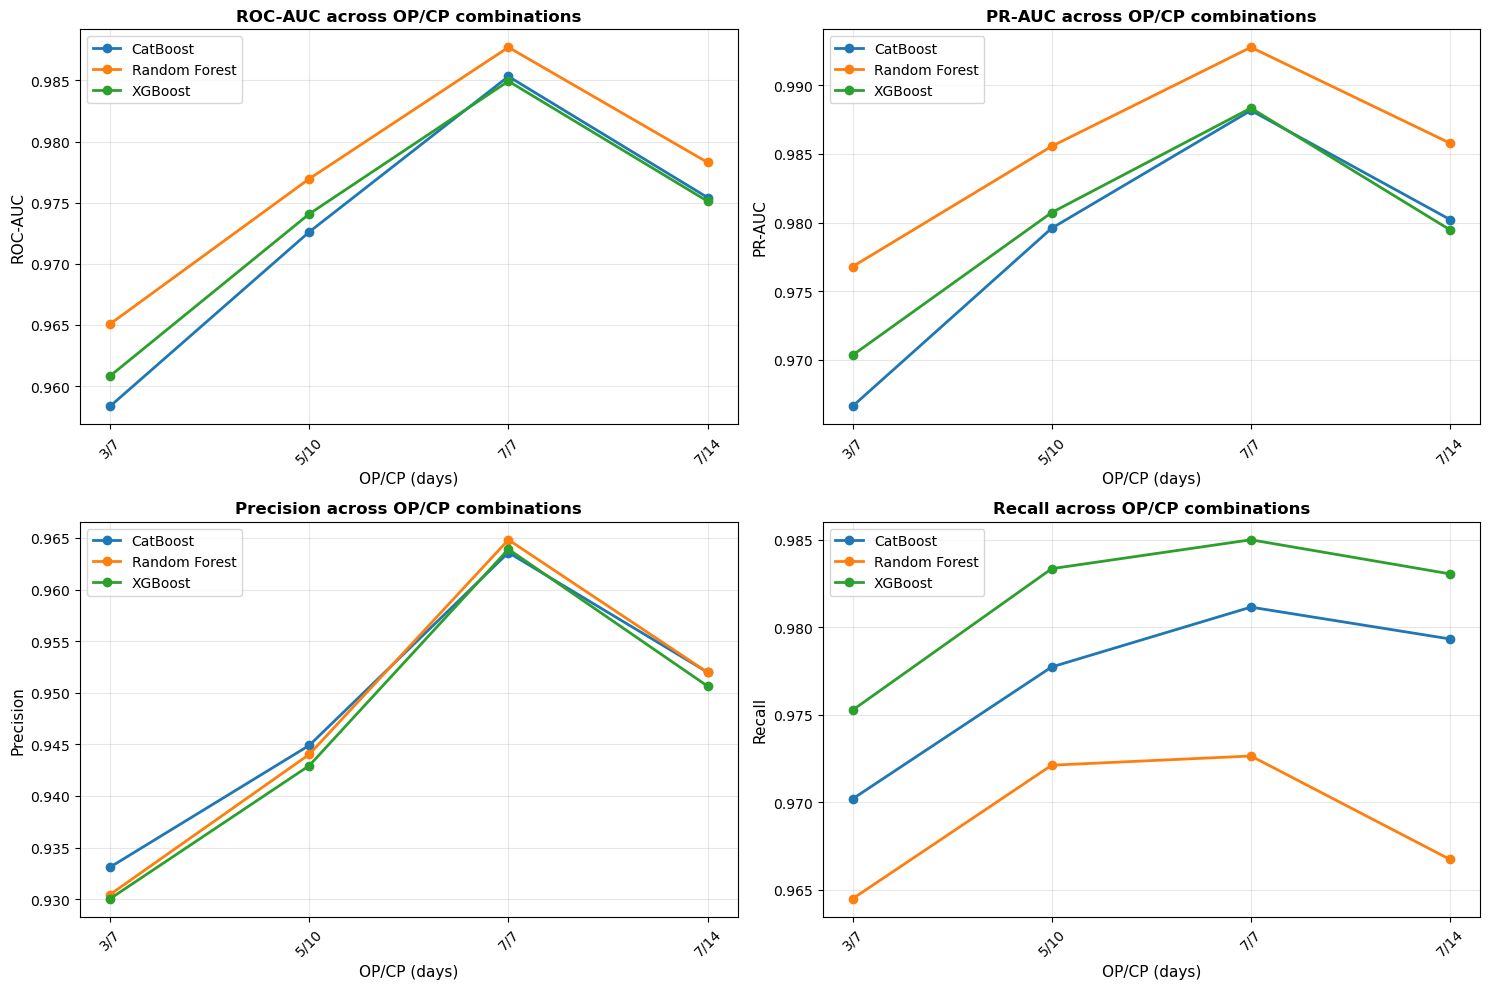

In [108]:
## 6. Visualize OP/CP Comparison Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['ROC-AUC', 'PR-AUC', 'Precision', 'Recall']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        model_data['OP_CP'] = model_data['OP'].astype(str) + '/' + model_data['CP'].astype(str)
        ax.plot(model_data['OP_CP'], model_data[metric], marker='o', linewidth=2, label=model)
    
    ax.set_xlabel('OP/CP (days)', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} across OP/CP combinations', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time

# Parameter search space
rf_param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [30, 40, 50, 60, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Run tuning
rf_search.fit(X_train, y_train)

print(" Best Parameters (Random Forest)")
for k, v in rf_search.best_params_.items():
    print(f"  {k:20s}: {v}")

print(f"\nBest CV ROC-AUC: {rf_search.best_score_:.4f}")

# Overfitting check
cv_results_df = pd.DataFrame(rf_search.cv_results_)
best_idx = rf_search.best_index_

train_cv = cv_results_df.loc[best_idx, 'mean_train_score']
test_cv  = cv_results_df.loc[best_idx, 'mean_test_score']
gap = train_cv - test_cv

print("\nOverfitting Check:")
print(f"  Train CV Score: {train_cv:.4f}")
print(f"  Valid CV Score: {test_cv:.4f}")
print(f"  Gap: {gap:.4f}")

# Evaluate on Test Set

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

tuned_rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf)
}

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
tuned_rf_metrics['PR-AUC'] = auc(recall_rf, precision_rf)

print(" Test Set Performance (Tuned RF)")
for metric, value in tuned_rf_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Best Parameters (Random Forest)
  n_estimators        : 400
  min_samples_split   : 2
  min_samples_leaf    : 1
  max_features        : log2
  max_depth           : 70
  class_weight        : balanced
  bootstrap           : True

Best CV ROC-AUC: 0.9722

Overfitting Check:
  Train CV Score: 1.0000
  Valid CV Score: 0.9722
  Gap: 0.0278
 Test Set Performance (Tuned RF)
  Accuracy    : 0.9472
  Precision   : 0.9519
  Recall      : 0.9698
  F1-Score    : 0.9608
  ROC-AUC     : 0.9786
  PR-AUC      : 0.9861


In [110]:
# Hyperparameter Tuning - XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import time

# Parameter search space
xgb_param_dist = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth': [6, 7, 8, 9, 10],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
    'min_child_weight': [1, 3, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

# Run tuning
xgb_search.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k:20s}: {v}")

print(f"Best CV ROC-AUC: {xgb_search.best_score_:.4f}")

# Overfitting check
cv_df = pd.DataFrame(xgb_search.cv_results_)
best_idx = xgb_search.best_index_

train_cv = cv_df.loc[best_idx, 'mean_train_score']
test_cv  = cv_df.loc[best_idx, 'mean_test_score']
gap = train_cv - test_cv

print("\nOverfitting Check:")
print(f"  Train CV Score: {train_cv:.4f}")
print(f"  Valid CV Score: {test_cv:.4f}")
print(f"  Gap:           {gap:.4f} {'(Overfitting!)' if gap > 0.05 else '(Good)'}")

# Evaluate tuned model on test set

best_xgb = xgb_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

tuned_xgb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_prob_xgb)
}

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
tuned_xgb_metrics['PR-AUC'] = auc(recall_xgb, precision_xgb)

print(" Test Set Performance (Tuned XGBoost)")
for metric, value in tuned_xgb_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")



Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters:
  subsample           : 0.7
  reg_lambda          : 1
  reg_alpha           : 0.5
  n_estimators        : 500
  min_child_weight    : 1
  max_depth           : 10
  learning_rate       : 0.07
  gamma               : 0.2
  colsample_bytree    : 0.7
Best CV ROC-AUC: 0.9727

Overfitting Check:
  Train CV Score: 1.0000
  Valid CV Score: 0.9727
  Gap:           0.0273 (Good)
 Test Set Performance (Tuned XGBoost)
  Accuracy    : 0.9556
  Precision   : 0.9527
  Recall      : 0.9822
  F1-Score    : 0.9672
  ROC-AUC     : 0.9762
  PR-AUC      : 0.9812


In [112]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Hyperparameter Tuning - CatBoost
cat_param_dist = {
    'iterations': [200, 300, 400],
    'depth': [8, 9, 10, 11],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1.0]
}


# Randomized Search
cat_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(random_seed=42, verbose=0),
    param_distributions=cat_param_dist,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)
cat_search.fit(X_train, y_train)


# Best parameters
print("\nBest Parameters:")
for k, v in cat_search.best_params_.items():
    print(f"  {k:20s}: {v}")

print(f"\nBest CV Score: {cat_search.best_score_:.4f}")

# Overfitting check
cv_results_df = pd.DataFrame(cat_search.cv_results_)
best_idx = cat_search.best_index_

train_score = cv_results_df.loc[best_idx, 'mean_train_score']
test_score = cv_results_df.loc[best_idx, 'mean_test_score']
gap = train_score - test_score

print("\nOverfitting Check:")
print(f"  Train Score: {train_score:.4f}")
print(f"  CV Score:    {test_score:.4f}")
print(f"  Gap:         {gap:.4f}")

# Test evaluation
best_cat = cat_search.best_estimator_
y_pred_cat = best_cat.predict(X_test)
y_prob_cat = best_cat.predict_proba(X_test)[:, 1]

cat_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred_cat),
    'Precision': precision_score(y_test, y_pred_cat),
    'Recall': recall_score(y_test, y_pred_cat),
    'F1-Score': f1_score(y_test, y_pred_cat),
    'ROC-AUC': roc_auc_score(y_test, y_prob_cat)
}

precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_prob_cat)
cat_tuned['PR-AUC'] = auc(recall_cat, precision_cat)




Best Parameters:
  learning_rate       : 0.1
  l2_leaf_reg         : 1
  iterations          : 400
  depth               : 11
  border_count        : 64
  bagging_temperature : 0

Best CV Score: 0.9735

Overfitting Check:
  Train Score: 0.9999
  CV Score:    0.9735
  Gap:         0.0264


## 10. Model Performance Comparison

In [113]:
# Create summary dataframe for tuning results
tuned_rf_metrics = tuned_rf_metrics
tuned_xgb_metrics = tuned_xgb_metrics
tuned_cat_metrics = cat_tuned


summary_df = pd.DataFrame([
tuned_rf_metrics,
tuned_xgb_metrics,
tuned_cat_metrics
], index=["Random Forest", "XGBoost", "CatBoost"])


print("SUMMARY OF TUNED MODEL PERFORMANCE:")
print(summary_df)

SUMMARY OF TUNED MODEL PERFORMANCE:
               Accuracy  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
Random Forest  0.947238   0.951927  0.969828  0.960794  0.978571  0.986057
XGBoost        0.955641   0.952696  0.982228  0.967236  0.976237  0.981226
CatBoost       0.955641   0.955435  0.979128  0.967136  0.976719  0.981693


In [ ]:
best_models = summary_df.idxmax()
print("\nBEST MODEL FOR EACH METRIC:")
print(best_models)


BEST MODEL FOR EACH METRIC:
Accuracy          CatBoost
Precision         CatBoost
Recall             XGBoost
F1-Score          CatBoost
ROC-AUC      Random Forest
PR-AUC       Random Forest
dtype: object


In [ ]:
# Extract CV scores from tuning objects
cv_scores = {
"Random Forest": rf_search.best_score_,
"XGBoost": xgb_search.best_score_,
"CatBoost": cat_search.best_score_
}


# Extract Test ROC-AUC from summary table
test_scores = summary_df["ROC-AUC"].to_dict()


cv_test_comparison = pd.DataFrame({
"CV ROC-AUC": cv_scores,
"Test ROC-AUC": test_scores
})


cv_test_comparison["Gap (CV - Test)"] = cv_test_comparison["CV ROC-AUC"] - cv_test_comparison["Test ROC-AUC"]


print("\nCROSS-VALIDATION VS TEST SET COMPARISON:")
print(cv_test_comparison)


CROSS-VALIDATION VS TEST SET COMPARISON:
               CV ROC-AUC  Test ROC-AUC  Gap (CV - Test)
Random Forest    0.969152      0.975839        -0.006687
XGBoost          0.971699      0.975531        -0.003831
CatBoost         0.971642      0.975458        -0.003817


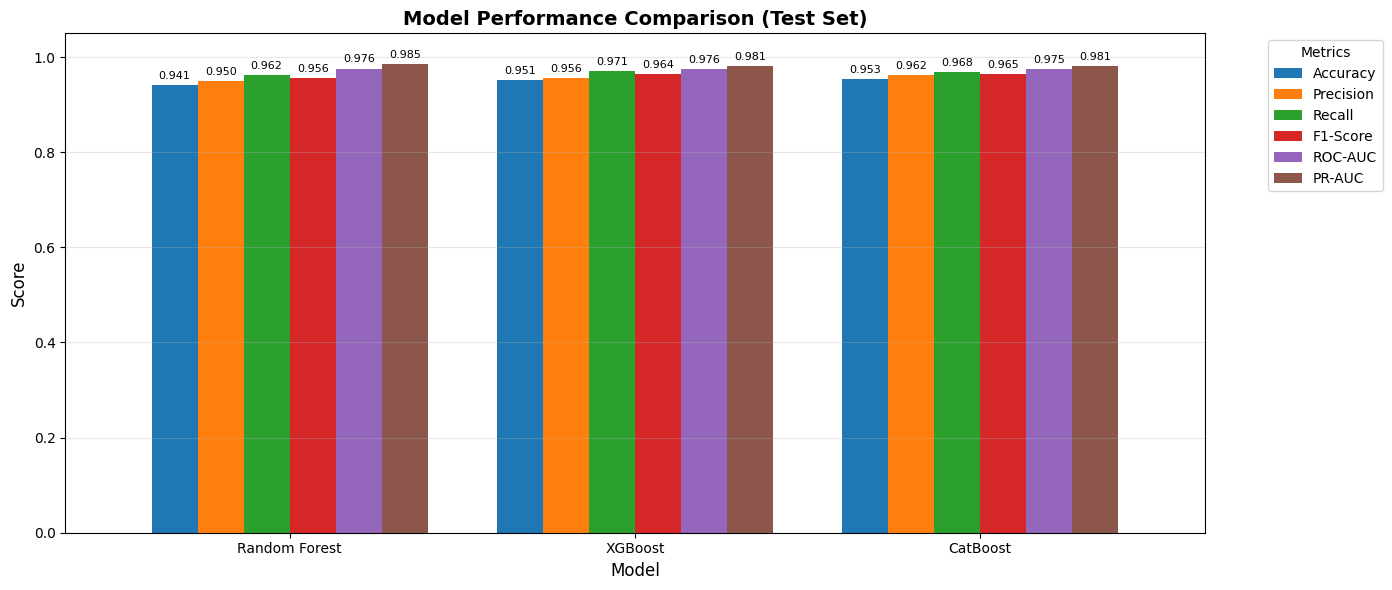

In [ ]:
# Test Set Metrics Comparison
fig, ax = plt.subplots(figsize=(14, 6))
summary_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Model Performance Comparison (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(summary_df.index, rotation=0)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
plt.tight_layout()
plt.show()

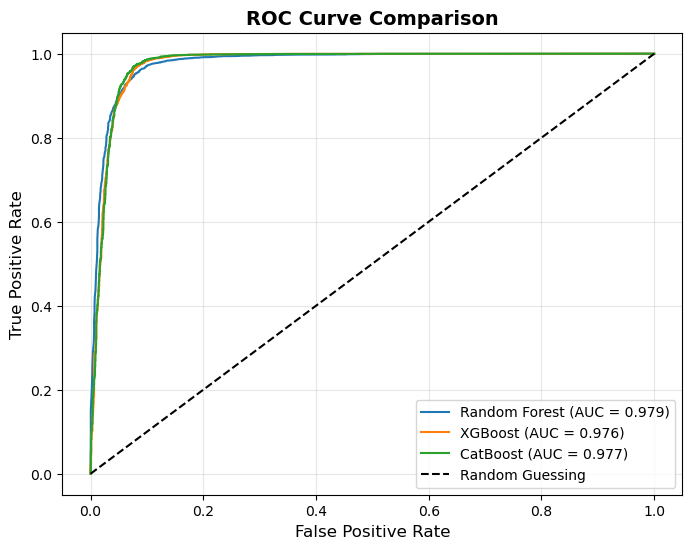

In [114]:
# 2. ROC Curves Comparison
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_prob_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(tuned_rf_metrics['ROC-AUC']))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.3f})'.format(tuned_xgb_metrics['ROC-AUC']))
plt.plot(fpr_cat, tpr_cat, label='CatBoost (AUC = {:.3f})'.format(tuned_cat_metrics['ROC-AUC']))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

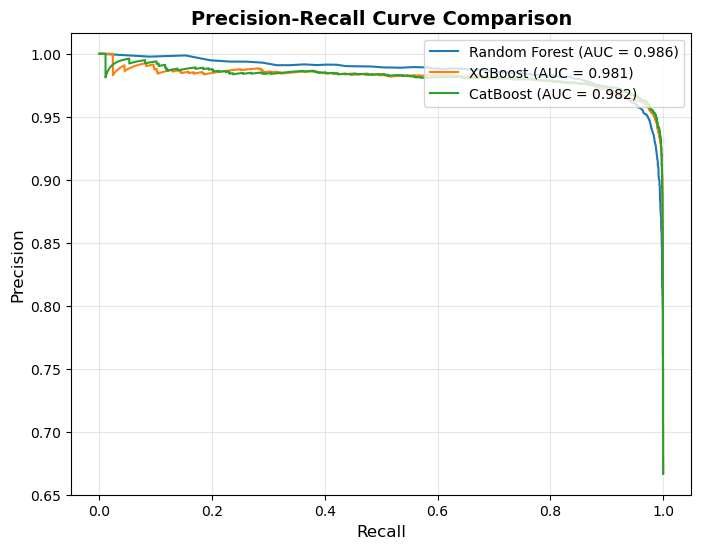

In [115]:
# 3. Precision-Recall Curves Comparison
from sklearn.metrics import precision_recall_curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_prob_cat)
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label='Random Forest (AUC = {:.3f})'.format(tuned_rf_metrics['PR-AUC']))
plt.plot(recall_xgb, precision_xgb, label='XGBoost (AUC = {:.3f})'.format(tuned_xgb_metrics['PR-AUC']))
plt.plot(recall_cat, precision_cat, label='CatBoost (AUC = {:.3f})'.format(tuned_cat_metrics['PR-AUC']))
plt.title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 5. CV vs Test Performance Comparison


## 11. Feature Importance Analysis


=== SHAP Analysis for Tuned CatBoost ===


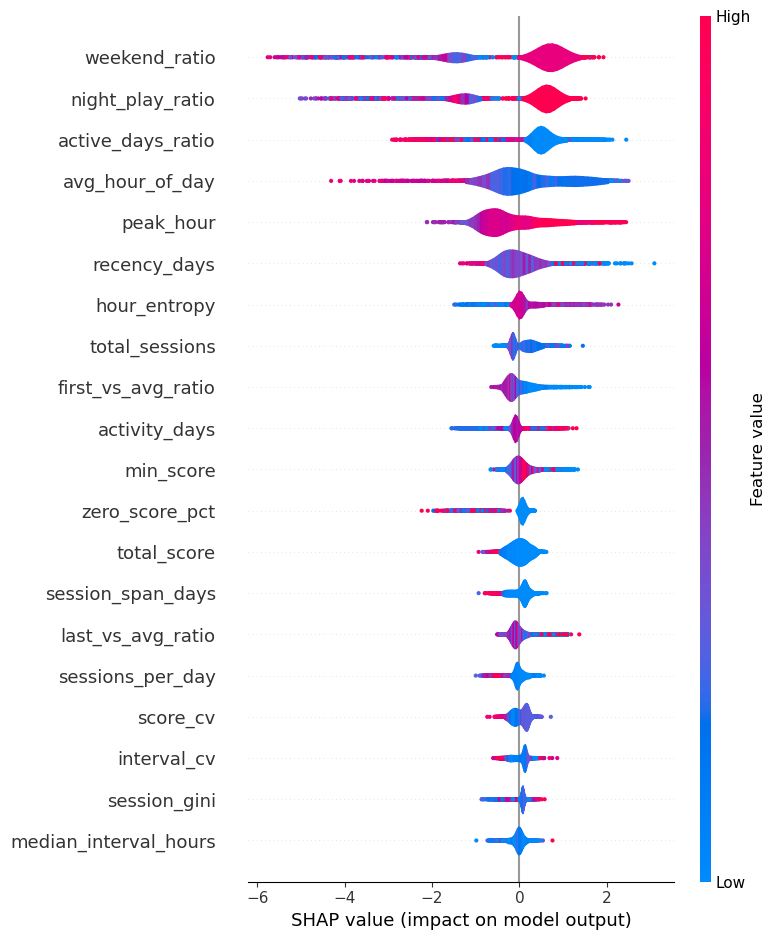

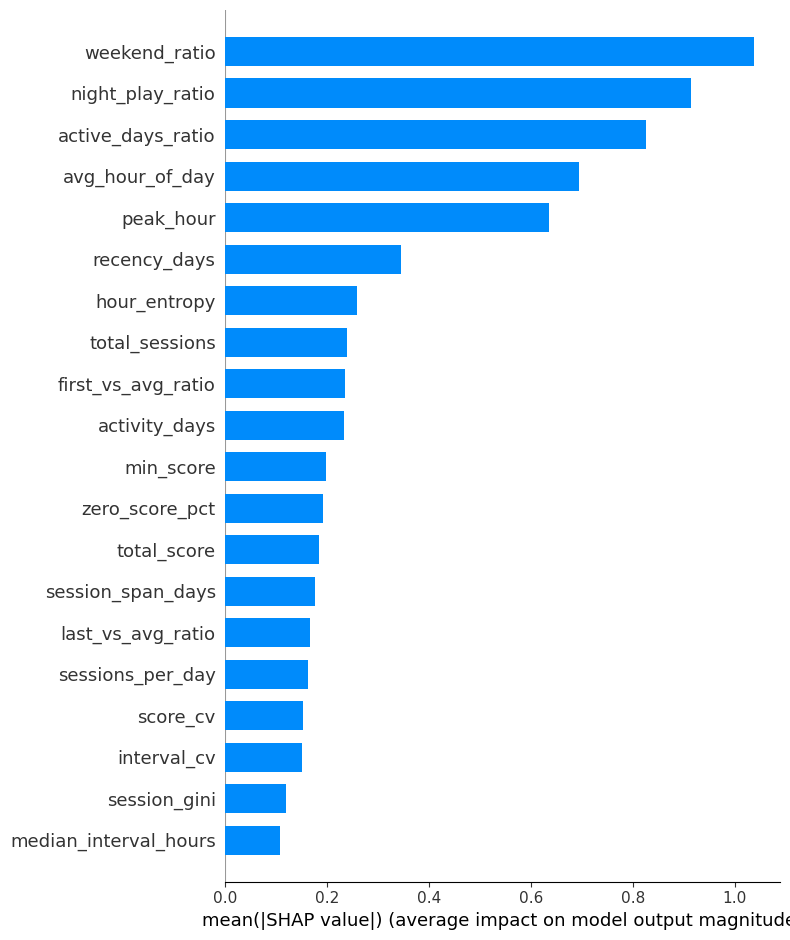

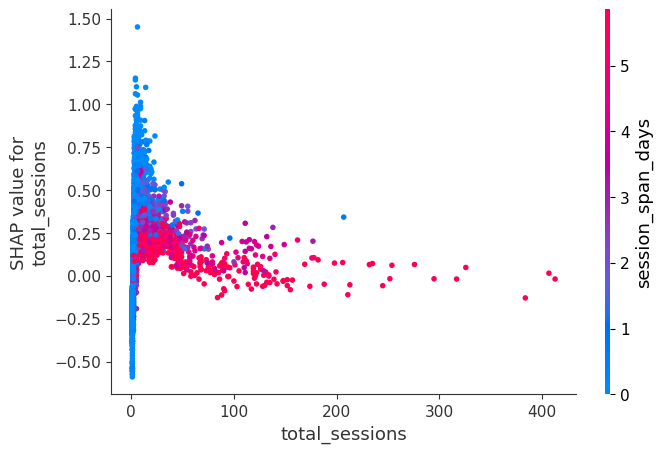

In [116]:
import shap

print("\n=== SHAP Analysis for Tuned CatBoost ===")

# Initialize SHAP
explainer = shap.TreeExplainer(best_cat)

# Compute SHAP values on test set
shap_values = explainer.shap_values(X_test)

# Summary plot (violin)
shap.summary_plot(shap_values, X_test, plot_type="violin")

# Bar plot (importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Example dependence plot for top feature
top_feature = X_test.columns[0]
shap.dependence_plot(top_feature, shap_values, X_test)

# Example local explanation
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])


In [118]:
import pandas as pd
import numpy as np

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Build importance table
shap_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP|': mean_abs_shap
})

# Sort and take top 10
top10_shap = shap_importance_df.sort_values('Mean |SHAP|', ascending=False).head(10)

print("\nTop 10 Most Important Features (by SHAP):")
print(top10_shap.to_string(index=False))




Top 10 Most Important Features (by SHAP):
           Feature  Mean |SHAP|
     weekend_ratio     1.036499
  night_play_ratio     0.913713
 active_days_ratio     0.825930
   avg_hour_of_day     0.693659
         peak_hour     0.635164
      recency_days     0.344227
      hour_entropy     0.258505
    total_sessions     0.238451
first_vs_avg_ratio     0.233984
     activity_days     0.232989
